In [1]:
import tensorflow as tf
from flows import NormalRW, DFlow, ResFlow, NVPFlow, phase, Normal, floatX, MVNormal, MVNormalRW
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

np.random.seed(1234)

In [2]:
n = 32
s1 = 0.01
m1 = 0.
s0 = 0.5
dim = [2,3]

params = []
params.append(np.random.normal(size=dim, scale=s0))
for i in range(n-1):
    new = params[i] + np.random.normal(loc=m1, scale=s1, size=dim)
    params.append(new)
params = np.array(params)

#PWalk = NormalRW(dim[0]*dim[1], sigma=s1, mu=m1, sigma0=s0)
PWalk = MVNormalRW(dim[0]*dim[1], sigma=s1, sigma0=s0, name='param_walk_prior')

In [3]:
params.shape

(32, 2, 3)

In [4]:
def autoregr(X, param):
    d = param[:,:dim[-1]-1]
    X = np.matmul(X, d) + param[:,-1][np.newaxis] + np.random.normal(size=[1,dim[-1]-1], scale=0.1)
    return X

def autoregr_tf(X, param):
    d = param[:,:dim[-1]-1]
    X = tf.matmul(X, d) + param[:,-1][np.newaxis]
    return X

In [5]:
xs = [np.random.normal(size=[1,dim[0]])]
for i in range(n-1):
    xs.append(autoregr(xs[i], params[i]))
xs = np.concatenate(xs)[np.newaxis].astype(floatX)

In [6]:
xs[:,:6]

array([[[-1.24765292,  0.24945522],
        [ 0.44137076,  1.37305072],
        [ 0.61883915, -0.22420247],
        [ 0.88275465,  0.19877301],
        [ 0.99636573, -0.27416369],
        [ 0.91369646,  0.04250122]]])

In [7]:
def create_step_flow(name=None, prev_flow_output=None, init_sigma=1.):
    with tf.variable_scope(name, reuse=False):
        
        if prev_flow_output is not None:
            aux_vars = prev_flow_output
        else:
            aux_vars = None
            
        step_flow = DFlow([ResFlow(dim=dim[0]*dim[1], name='res{}'.format(i), aux_vars=aux_vars)\
                           for i in range(4)], init_sigma=init_sigma)
    return step_flow

In [8]:
flows = [create_step_flow('step_flow0', init_sigma=s0)]
outputs = [flows[-1].output]
for i in range(n-1):
    new = create_step_flow('step_flow' + str(i+1), outputs[-1], init_sigma=s1)
    flows.append(new)
    outputs.append(outputs[-1] + new.output)

In [9]:
outputs = tf.concat(outputs, axis=0)[tf.newaxis]

In [10]:
outputs

<tf.Tensor 'strided_slice:0' shape=(1, 32, 6) dtype=float64>

In [11]:
prior = PWalk.logdens(outputs)

In [12]:
prior

<tf.Tensor 'param_walk_prior_2/logdens/add:0' shape=() dtype=float64>

In [13]:
def create_loglik():
    obs_d = Normal(dim=None, sigma=0.1, mu=0)
    out = tf.reshape(outputs, [n, dim[0], dim[1]])
    
    ll = 0
    for i in range(n-1):
        pred = xs[0,i+1] - autoregr_tf(xs[0,i][np.newaxis], out[i])
        ll += obs_d.logdens(pred)
    return ll

def create_loglik2():
    obs_d = Normal(dim=None, sigma=0.1, mu=0)
    out = tf.reshape(outputs, [n, dim[0], dim[1]])
    
    def step1(current):
        X = current[0][np.newaxis]
        param = current[1]
        d = param[:,:dim[-1]-1]
        X = tf.matmul(X, d)[0] + param[:,-1]
        return X
    
    ar = tf.map_fn(step1, (xs[0][:-1], out[:-1]), dtype=tf.float64)
    return obs_d.logdens(ar - xs[0][1:])

In [14]:
logl = create_loglik2()

In [15]:
ent = tf.reduce_sum([flow.logdens for flow in flows])

In [16]:
ent

<tf.Tensor 'Sum_1:0' shape=() dtype=float64>

In [17]:
loss = -logl - prior + ent
loss /= n*dim[0]*dim[1]

In [18]:
opt = tf.train.AdamOptimizer(0.0001).minimize(loss)

In [19]:
sess = tf.InteractiveSession()

In [20]:
tf.global_variables_initializer().run()

In [21]:
prior.eval(), ent.eval(), logl.eval()

(478.51181785838617, 792.2331595883334, -7161.860346694852)

In [22]:
loss.eval()

32.637170916789955

In [23]:
np.set_printoptions(precision=4)

In [24]:
PWalk.inverse_sigma.eval()[:3,:3]

array([[10000.    ,   105.7633,    51.3082],
       [  105.7633, 10001.1186,   -54.099 ],
       [   51.3082,   -54.099 , 10000.5618]])

In [ ]:
%%time
for _ in range(500):
    for _ in range(400):
        l, _ = sess.run([loss, opt], {phase:True})
    print(l)
    print(PWalk.inverse_sigma.eval()[:3,:3])
    print('\n')

3.3020148943182064
[[9177.766   103.3239   45.2392]
 [ 103.3239 9349.578   -50.2795]
 [  45.2392  -50.2795 9201.3905]]


4.050027744514246
[[8462.2178  100.7649   39.2455]
 [ 100.7649 8803.1423  -46.9875]
 [  39.2455  -46.9875 8463.6865]]


1.8719440106707899
[[7875.2033   98.5072   34.3101]
 [  98.5072 8346.3297  -44.1404]
 [  34.3101  -44.1404 7849.5058]]


4.441938012492052
[[7382.798    96.3588   30.0766]
 [  96.3588 7922.5249  -41.7383]
 [  30.0766  -41.7383 7331.5028]]


1.0729005287220883
[[6980.6122   94.6018   26.5787]
 [  94.6018 7527.0216  -39.6512]
 [  26.5787  -39.6512 6914.7442]]


4.22242929183994
[[6606.0738   92.8031   23.2709]
 [  92.8031 7163.7536  -37.7856]
 [  23.2709  -37.7856 6526.6145]]


3.6862155090374156
[[6278.9074   90.9134   20.3754]
 [  90.9134 6864.5091  -36.4623]
 [  20.3754  -36.4623 6193.669 ]]


4.497750169414223
[[6018.3738   89.5457   18.0025]
 [  89.5457 6608.8209  -35.141 ]
 [  18.0025  -35.141  5925.9392]]


3.780512804741729
[[5766.8413   88.03

In [24]:
out = tf.reshape(outputs, [n, 3, 4])

In [25]:
samples = []
for _ in range(1000):
    s = out.eval()
    samples.append(s)
samples = np.array(samples)

In [26]:
samples.shape

(1000, 32, 3, 4)

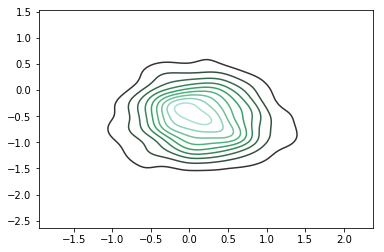

In [27]:
sns.kdeplot(samples[:,1,2,3], samples[:,1,2,1])
plt.show()

In [28]:
t = 18
params[t]

array([[ 0.26256903, -0.6518162 ,  0.74696963, -0.15384126],
       [-0.3732683 ,  0.49052328,  0.44550811, -0.37385512],
       [ 0.05862716, -1.18001719,  0.62563793,  0.5192165 ]])

In [29]:
np.mean(samples[:,t], axis=0)

array([[ 0.29352756, -0.48678149,  0.18031565,  0.13995509],
       [-0.29175221,  0.56575757,  0.02895212, -0.53603244],
       [ 0.01158709, -0.57025248,  0.31307119,  0.12096679]])